<a href="https://colab.research.google.com/github/chosunghyun18/ML_DL_Statics/blob/main/Muffin_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import os & set tpu
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
#from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical, load_img
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
IMAGE_PATH = "/content/drive/MyDrive/CNN-DataSeminar/data/archive/train/dog"
filenames = os.listdir(IMAGE_PATH)

In [ ]:
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df.tail()

,filename,category
11146,muffin.4054.jpg,0
11147,muffin.2992.jpg,0
11148,muffin.4940.jpg,0
11149,muffin.194.jpg,0
11150,muffin.4969.jpg,0


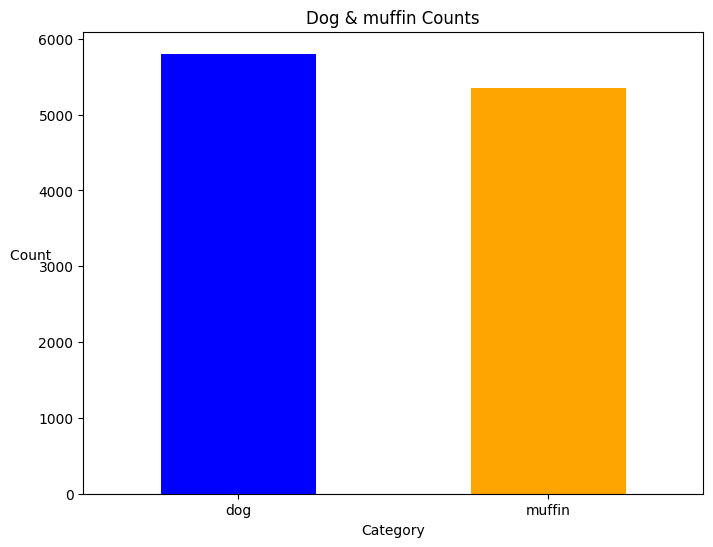

In [ ]:
# 데이터프레임에서 카테고리별 카운트 구하기
category_counts = df['category'].value_counts()

plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color=['blue', 'orange'])
plt.xticks([0, 1], ['dog', 'muffin'], rotation=0)
plt.xlabel('Category', rotation=0)
plt.ylabel('Count ', rotation=0)
plt.title('Dog & muffin Counts')
plt.show()

In [ ]:
df["category"] = df["category"].replace({0: 'muffin', 1: 'dog'})

In [ ]:
df.head()
df.tail

<bound method NDFrame.tail of               filename category
0         dog.4386.jpg      dog
1         dog.5098.jpg      dog
2         dog.2091.jpg      dog
3         dog.1375.jpg      dog
4         dog.1598.jpg      dog
...                ...      ...
11146  muffin.4054.jpg   muffin
11147  muffin.2992.jpg   muffin
11148  muffin.4940.jpg   muffin
11149   muffin.194.jpg   muffin
11150  muffin.4969.jpg   muffin

[11151 rows x 2 columns]>

In [ ]:
# Define the random seed for reproducibility
random_seed = 42

# Perform a stratified split to maintain class proportions
train_df, validate_df = train_test_split(df, test_size=0.10, random_state=random_seed, stratify=df['category'])

train_dog_count = train_df['category'].value_counts().get('dog', 0)
train_muffin_count = train_df['category'].value_counts().get('muffin', 0)

validate_dog_count = validate_df['category'].value_counts().get('dog', 0)
validate_muffin_count = validate_df['category'].value_counts().get('muffin', 0)

print("Train Data - Dog count:", train_dog_count)
print("Train Data - Muffin count:", train_muffin_count)
print("Validate Data - Dog count:", validate_dog_count)
print("Validate Data - Muffin count:", validate_muffin_count)

print(train_dog_count + validate_dog_count)
print(train_muffin_count + validate_muffin_count)


Train Data - Dog count: 5223
Train Data - Muffin count: 4812
Validate Data - Dog count: 581
Validate Data - Muffin count: 535
5804
5347


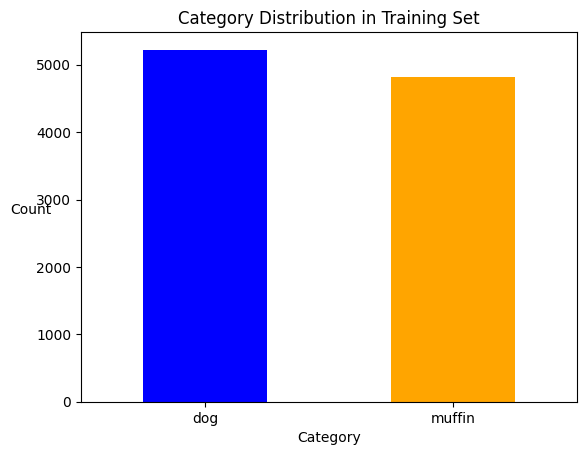

In [ ]:
category_counts = train_df['category'].value_counts()
colors = ['orange' if muffin == 'muffin' else 'blue' for muffin in category_counts.index]

category_counts.plot(kind='bar', color=colors)

# Set x-axis label with rotation=0 (no rotation)
plt.xticks(rotation=0)

# Set labels and title
plt.xlabel('Category', rotation=0)
plt.ylabel('Count', rotation=0)
plt.title('Category Distribution in Training Set')

# Show the plot
plt.show()

In [ ]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
batch_size = 64

In [ ]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]


print(total_train)
print(total_validate)


train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    IMAGE_PATH+"/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    IMAGE_PATH+"/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

10035
1116
Found 10035 validated image filenames belonging to 2 classes.
Found 1116 validated image filenames belonging to 2 classes.


In [ ]:
### model arch
model = Sequential()

model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (4, 4), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512, activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 124, 124, 32)      2432      
                                                                 
 batch_normalization_4 (Batc  (None, 124, 124, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 62, 62, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 59, 59, 64)        32832     
                                                                 
 batch_normalization_5 (Batc  (None, 59, 59, 64)      

In [ ]:
earlystop = EarlyStopping(patience=3) # EarlyStop
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',patience = 5,factor=0.2,min_lr=0.00001,verbose=1,)
callbacks = [earlystop, learning_rate_reduction]
epochs = 50
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50
 23/156 [===>..........................] - ETA: 11:36 - loss: 0.7935 - accuracy: 0.7167

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


156/156 [==============================] - ETA: 0s - loss: 0.4863 - accuracy: 0.7986

156/156 [==============================] - 1240s 6s/step - loss: 0.4863 - accuracy: 0.7986 - val_loss: 8.4751 - val_accuracy: 0.5202 - lr: 0.0010
Epoch 2/50
156/156 [==============================] - ETA: 0s - loss: 0.3742 - accuracy: 0.8495

156/156 [==============================] - 882s 6s/step - loss: 0.3742 - accuracy: 0.8495 - val_loss: 3.9317 - val_accuracy: 0.5239 - lr: 0.0010
Epoch 3/50
156/156 [==============================] - ETA: 0s - loss: 0.3085 - accuracy: 0.8752

156/156 [==============================] - 855s 5s/step - loss: 0.3085 - accuracy: 0.8752 - val_loss: 1.2725 - val_accuracy: 0.6039 - lr: 0.0010
Epoch 4/50
156/156 [==============================] - ETA: 0s - loss: 0.2632 - accuracy: 0.8968

156/156 [==============================] - 852s 5s/step - loss: 0.2632 - accuracy: 0.8968 - val_loss: 1.7955 - val_accuracy: 0.6140 - lr: 0.0010
Epoch 5/50
156/156 [==============================] - ETA: 0s - loss: 0.2351 - accuracy: 0.9041

156/156 [==============================] - 884s 6s/step - loss: 0.2351 - accuracy: 0.9041 - val_loss: 0.2846 - val_accuracy: 0.8860 - lr: 0.0010
Epoch 6/50
156/156 [==============================] - ETA: 0s - loss: 0.2226 - accuracy: 0.9139

156/156 [==============================] - 874s 6s/step - loss: 0.2226 - accuracy: 0.9139 - val_loss: 0.3415 - val_accuracy: 0.8676 - lr: 0.0010
Epoch 7/50
156/156 [==============================] - ETA: 0s - loss: 0.2020 - accuracy: 0.9195

156/156 [==============================] - 844s 5s/step - loss: 0.2020 - accuracy: 0.9195 - val_loss: 0.3013 - val_accuracy: 0.8704 - lr: 0.0010
Epoch 8/50
156/156 [==============================] - ETA: 0s - loss: 0.1901 - accuracy: 0.9255

156/156 [==============================] - 869s 6s/step - loss: 0.1901 - accuracy: 0.9255 - val_loss: 0.4864 - val_accuracy: 0.8502 - lr: 0.0010


In [ ]:
model.save("/content/drive/MyDrive/CNN-DataSeminar/data/archive/model_large_muffin_image.h5")

NameError: ignored

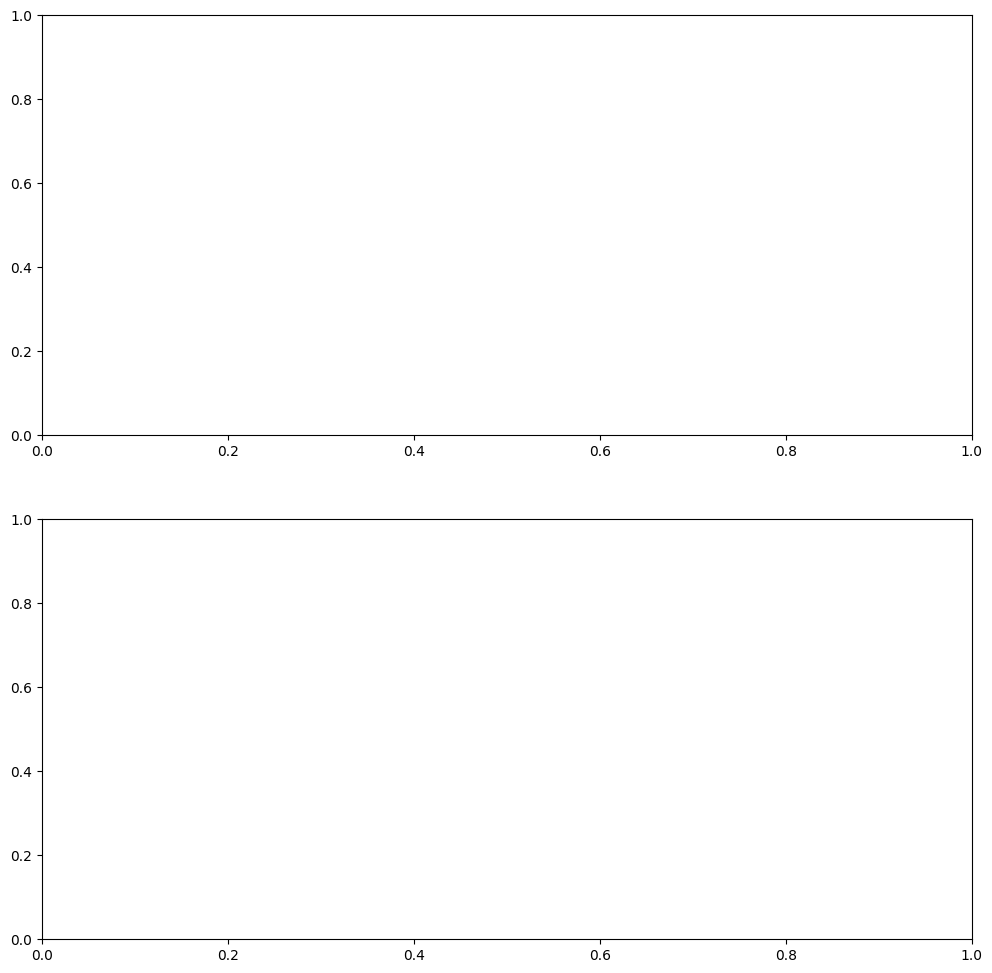

In [ ]:
#show : #Save
model.save_weights("model large image")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Training loss와 validation loss 그래프 추가
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(np.arange(1, 51, 1))
ax1.set_yticks(np.arange(0, max(history.history['loss']), 0.1))  # 적절한 y 범위 설정

# Training accuracy와 validation accuracy 그래프 추가
ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 51, 1))

# legend 추가
legend1 = ax1.legend(loc='upper right', shadow=True)
legend2 = ax2.legend(loc='upper right', shadow=True)

# ACC 범례 위치를 우측 하단으로 이동
legend2.set_bbox_to_anchor((1, 0.1))  # (x, y) 좌표를 조절하여 범례 위치를 변경

# 그래프 간격 조절
plt.tight_layout()

# 그래프 표시

plt.show()

In [ ]:
model = load_model("/content/drive/MyDrive/CNN-DataSeminar/data/archive/model_cat_image.h5")

In [ ]:

# 이미지 업로드
from google.colab import files
uploaded = files.upload()

TypeError: ignored

In [ ]:
img_path = "catt.png"

1/1 [==============================] - 0s 237ms/step
[[0.99039537 0.00960469]]
Predicted Class: cat
Confidence: 99.04%


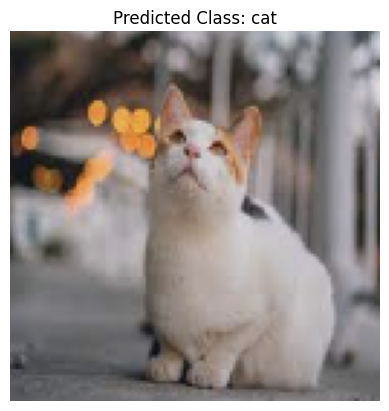

In [ ]:
# 이미지를 불러와서 전처리합니다.
img = image.load_img(img_path, target_size=(128, 128))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img/255.0  # 이미지 스케일링

# 예측 수행
predictions = model.predict(img)
print(predictions)
# 예측 결과 출력
class_names = ["cat", "dog"]
predicted_class = np.argmax(predictions, axis=1)[0]
predicted_class_name = class_names[predicted_class]

# 예측 결과 출력
print(f"Predicted Class: {predicted_class_name}")
print(f"Confidence: {predictions[0][predicted_class] * 100:.2f}%")

# 이미지 표시
plt.imshow(img[0])
plt.title(f"Predicted Class: {predicted_class_name}")
plt.axis('off')
plt.show()